<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/Supernovae_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Among the following models, which model fits the Pantheon supernovae compilation better? why?
$\Lambda$CDM, Flat $\Lambda$CDM, $w$CDM, Flat $w$CDM



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.cosmology import FlatLambdaCDM, LambdaCDM, wCDM,FlatwCDM
from scipy import optimize
import pandas as pd

# These packages are not installed by default on Google Colab, we may need to
# install them
# I am using try/except so that we only install them if they're not already
# installed:
try:
   import emcee
except:
  # emcee not installed, install it and import
  !pip install emcee
  import emcee
# same for corner:
try:
  import corner
except:
  !pip install corner
  import corner


models = ["FlatLCDM","LCDM",'FlatwCDM','wCDM']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.4 MB/s eta 0:00:00


In [3]:
z, mB, dmB = np.genfromtxt("https://raw.githubusercontent.com/dscolnic/Pantheon/master/lcparam_full_long.txt", skip_header=0, usecols=(1, 4, 5), unpack=True)
Nsn = len(z) # number of samples (data points)

Csys = np.genfromtxt("https://raw.githubusercontent.com/dscolnic/Pantheon/master/sys_full_long.txt", skip_header=1).reshape((Nsn,Nsn))
Cov=Csys + np.diag(dmB**2)

#invert the covarinace matrix
Cinv = np.linalg.inv(Cov)
err=np.sqrt(np.diag(Cov))

# creating a structured array:
data = np.zeros(Nsn,dtype=[('z',float),('mB',float),('dmB',float)])
data['z'] = z
data['mB'] = mB
data['dmB'] = dmB

# creating a dataframe to save my results
df = pd.DataFrame(columns=['Model','AIC','BIC','DIC','chi2min','chi2min/dof'])
df['Model'] = models



Plot the data

Text(0, 0.5, 'distance modulus, $\\mu$')

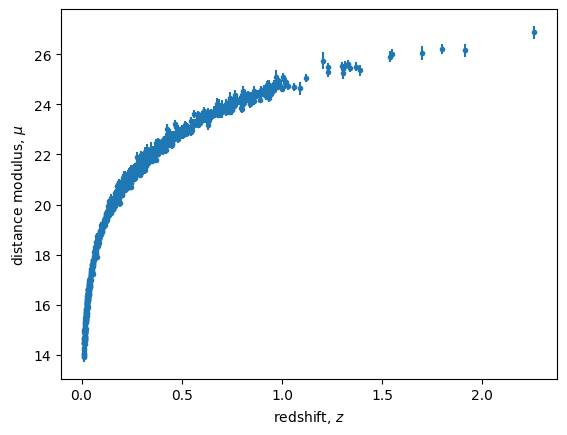

In [52]:
plt.errorbar(z,mB,yerr=err,fmt='.')
plt.xlabel(r'redshift, $z$')
plt.ylabel(r'distance modulus, $\mu$')

Lets look how the matter component effects the distance modulus

Text(0, 0.5, 'distance modulus, $\\mu$')

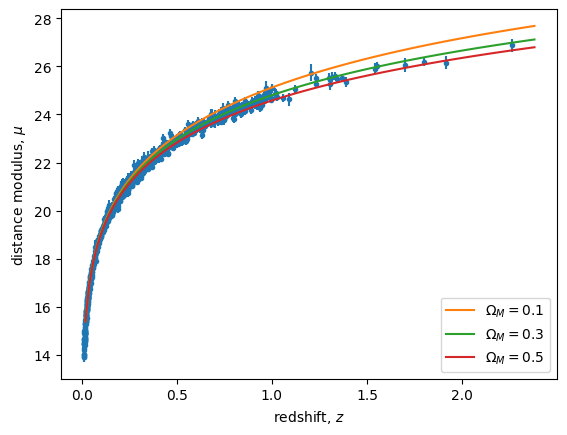

In [15]:
zs=np.arange(0,2.4,0.02)

plt.errorbar(z,mB,yerr=err,fmt='.',zorder=0)

cosmo = FlatLambdaCDM(Om0=0.1,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$\Omega_M=0.1$')

cosmo = FlatLambdaCDM(Om0=0.3,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$\Omega_M=0.3$')

cosmo = FlatLambdaCDM(Om0=0.5,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$\Omega_M=0.5$')
plt.legend(loc=4)

plt.xlabel(r'redshift, $z$')
plt.ylabel(r'distance modulus, $\mu$')

Lets look how the dark energy equation of state, w, effects the distance modulus

Text(0, 0.5, 'distance modulus, $\\mu$')

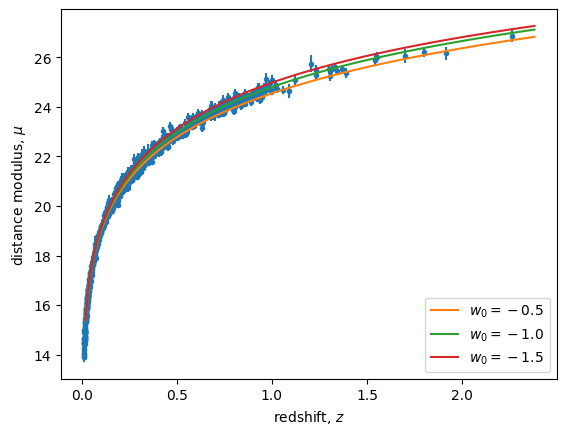

In [22]:
zs=np.arange(0,2.4,0.02)

plt.errorbar(z,mB,yerr=err,fmt='.',zorder=0)

cosmo = FlatwCDM(Om0=0.3,w0=-.5,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$w_0=-0.5$')

cosmo = FlatwCDM(Om0=0.3,w0=-1.,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$w_0=-1.0$')

cosmo = FlatwCDM(Om0=0.3,w0=-1.5,H0=70)
dy = cosmo.distmod(zs).value - 19.3
plt.plot(zs,dy,label=r'$w_0=-1.5$')
plt.legend(loc=4)

plt.xlabel(r'redshift, $z$')
plt.ylabel(r'distance modulus, $\mu$')

Plot the data covariance matrix

<ipython-input-23-df215f3a1a6b>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(Cov)))


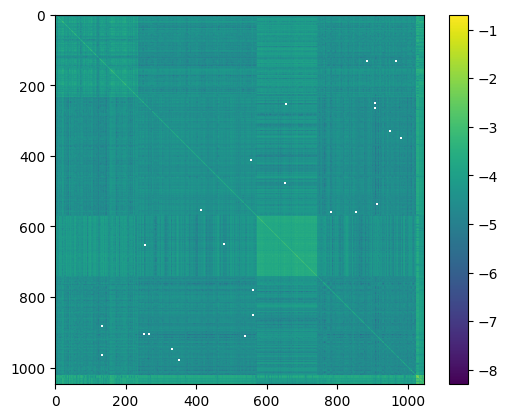

In [23]:
plt.imshow(np.log10(np.abs(Cov)))
plt.colorbar()

In [67]:
# Define my chi^2 (cost function):

def residuals(params,model,data):
  '''return chi^2

  order: Om0, Ode0, w,Mb
  '''
  assert model in [0,1,2,3], 'error, model={} unknown'.format(model)
  H0 = 70.
  if model == 0:
    Om0,MB = params
    cosmo = FlatLambdaCDM(Om0=Om0,H0=H0)
  elif model == 1:
    # LCDM:
    Om0,Ode0,MB = params
    cosmo = LambdaCDM(Om0=Om0,Ode0=Ode0,H0=H0)
  elif model == 2:
    # flat wCDM
    Om0,w,MB = params
    cosmo = FlatwCDM(Om0=Om0,w0=w,H0=H0)
  elif model == 3:
    Om0,Ode0,w,MB = params
    cosmo = wCDM(Om0=Om0,Ode0=Ode0,w0=w,H0=H0)

  dy = cosmo.distmod(data['z']).value - (data['mB'] - MB )
  chi2 = dy.T @ Cinv @ dy

  return chi2


Use the genetic algorithm method to find the maximum likelihood point

In [66]:
# minimizing chi2 = max likelihood

Nparams = [2,3,3,4] # number of parameters in each model
bounds = {}
bounds[0] = ((0,1),(-25,-15))
bounds[1] = ((0,1),(0,1),(-25,-15))
bounds[2] = ((0,1),(-2,0),(-25,-15))
bounds[3] = ((0,1),(0,1),(-2,0),(-25,-15))
thetahat = {}
for model in range(4):
  print (72*"=")
  print(" Model: {}".format(model))
  res = optimize.differential_evolution(residuals,bounds=bounds[model],args=(model,data))
  print (res)
  thetahat[model] = res.x
  chi2 = res.fun
  nu = Nsn-Nparams[model]
  print( " chi2/nu = {}/{} = {}".format(chi2,nu,chi2/nu))

  ii = df['Model'] == models[model]
  print (ii,df.loc[ii])
  df.loc[ii,'AIC'] = chi2 + 2*Nparams[model]
  df.loc[ii,'BIC'] = chi2 + Nparams[model] * np.log(Nsn)
  df.loc[ii,'chi2min'] = chi2
  df.loc[ii,'chi2min/dof'] = chi2/nu
  print (df)
  # print (" AIC={}".format(DIC))

print (df)

 Model: 0
 message: Optimization terminated successfully.
 success: True
     fun: 1026.86184930358
       x: [ 2.981e-01 -1.935e+01]
     nit: 10
    nfev: 360
     jac: [ 1.728e-03 -2.296e-03]
 chi2/nu = 1026.86184930358/1046 = 0.981703488817954
0     True
1    False
2    False
3    False
Name: Model, dtype: bool       Model          AIC          BIC  DIC      chi2min chi2min/dof
0  FlatLCDM  1030.861849  1040.771127  NaN  1026.861849    0.981703
      Model          AIC          BIC  DIC      chi2min chi2min/dof
0  FlatLCDM  1030.861849  1040.771127  NaN  1026.861849    0.981703
1      LCDM  1032.714967  1047.578883  NaN  1026.714967    0.982502
2  FlatwCDM   1032.81088  1047.674797  NaN   1026.81088    0.982594
3      wCDM  1034.417885   1054.23644  NaN  1026.417885    0.983159
 Model: 1
 message: Optimization terminated successfully.
 success: True
     fun: 1026.7149667209985
       x: [ 3.238e-01  7.442e-01 -1.935e+01]
     nit: 13
    nfev: 678
     jac: [ 1.592e-03  4.547e-05 

# MCMC

In [31]:
# Define my priors:

def lnpOm0(Om0):
  if 0<Om0<1:
    return 0
  else:
    return -np.inf


def lnpMB(MB):
  ''' Note: this is an unnormalized prior.
  The correct normalization would be -np.log(Mb_Max-Mb_min) = np.log(1/(Mbmax-Mbmin))
  '''
  if -25<MB<-15:
    return 0
  else:
    return -np.inf

def lnpOde0(Ode0):
  if 0<Ode0<1.4:
    return 0
  else:
    return -np.inf

def lnpw(ww):
  if -3<ww<0:
    return 0
  else:
    return -np.inf

def lnprior(theta,model):
  '''Returns the (unnormalized) prior'''
  Om0 = theta[0]
  MB = theta[-1]
  lp = lnpOm0(Om0) + lnpMB(MB)
  if model in [1,3]:
    Ode0 = theta[1]
    lp += lnpOde0(Ode0)
  if model in [2,3]:
    ww = theta[-2]
    lp += lnpw(ww)
  return lp

def lnP(theta,model,data):
  '''Calculate the log posterior
  ln P(theta) = ln pi(theta) + ln L (theta)
  Also return the log likelihood as a blob.
  '''
  # 1. Get the prior for the parameters theta
  lp = lnprior(theta,model)

  # are the parameters within the priors?
  if np.isfinite (lp):
    # Get the log likelihood
    ll = -.5*residuals(theta,model,data)
    return lp+ll,ll
  else:
    # my prior is zero so I don't need to calculate ln L,
    # I just return ln pi = -inf
    return lp,lp


# Calculate the DIC

In [68]:
def DIC (mysample,thetamean):
  # ln L = -.5*residuals(theta,model,data)
  ll = mysample.get_blobs(flat=True,thin=nthin,discard=nburn).mean()
  # chi2(\bar\theta) = residuals = -2 ln L(\hat\theta)
  return -4*ll  - residuals(thetamean,model,data)


# Ok, now we run everything:

100%|██████████| 2000/2000 [01:03<00:00, 31.33it/s]


[28.34500508 28.95393696]
(780, 2)
[  0.30018982 -19.34869564]
1030.8255972702111
      Model          AIC          BIC  DIC      chi2min chi2min/dof
0  FlatLCDM  1030.861849  1040.771127  NaN  1026.861849    0.981703
1      LCDM  1032.714967  1047.578883  NaN  1026.714967    0.982502
2  FlatwCDM   1032.81088  1047.674797  NaN   1026.81088    0.982594
3      wCDM  1034.417885   1054.23644  NaN  1026.417885    0.983159


<ipython-input-38-9f165beddf6a>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[model]['DIC'] = myDIC


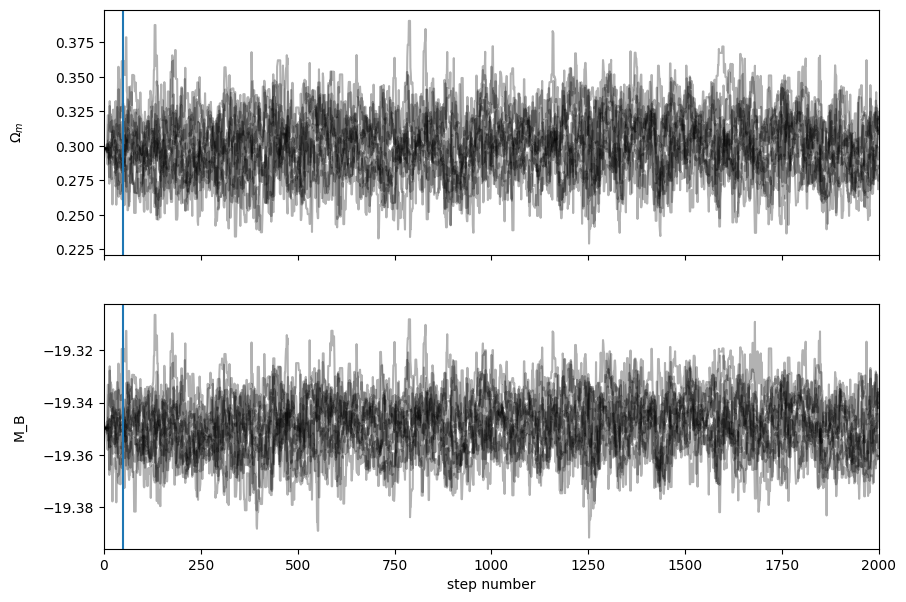

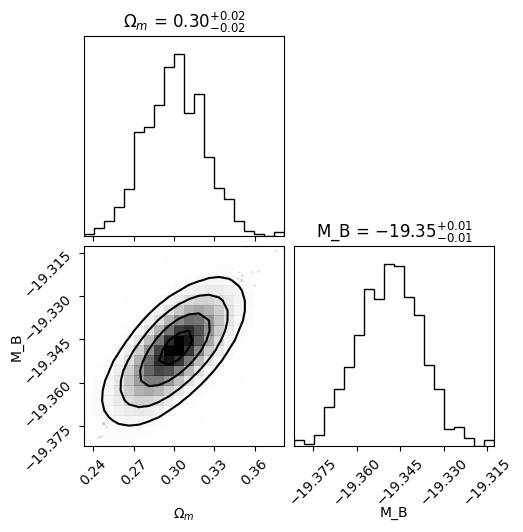

In [38]:


# fLCDM
model = 0
nwalker = 12
ndim = Nparams[model]
niter = 2000

theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True);



fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"M_B",]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number");


# AutocorrelatioN:
tau = sampler.get_autocorr_time()
print(tau)
nburn = 50
nthin = 30


flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)

fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("flat_lcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model]['DIC'] = DIC_value
print (df)

Plot the data again with the best fit for flat LCDM (model 0)

In [1]:
Om0,MB = thetamean
cosmo = FlatLambdaCDM(Om0=Om0,H0=H0)
zs=np.arange(0,2.4,0.02)

dy = cosmo.distmod(zs).value + MB

plt.errorbar(z,mB,yerr=err,fmt='.',zorder=0)
plt.plot(zs,dy)

NameError: name 'thetamean' is not defined

In [48]:
df

,Model,AIC,BIC,DIC,chi2min,chi2min/dof
0,FlatLCDM,1030.861849,1040.771127,NaN,1026.861849,0.981703
1,LCDM,1032.714967,1047.578883,NaN,1026.714967,0.982502
2,FlatwCDM,1032.81088,1047.674797,NaN,1026.81088,0.982594
3,wCDM,1034.417885,1054.23644,NaN,1026.417885,0.983159


100%|██████████| 3000/3000 [01:46<00:00, 28.19it/s]


[38.35139563 38.44123719 40.29083589]
(1176, 3)
[  0.3210553    0.73346734 -19.35121256]
1032.469817842631
      Model          AIC          BIC  DIC      chi2min chi2min/dof
0  FlatLCDM  1030.861849  1040.771127  NaN  1026.861849    0.981703
1      LCDM  1032.714967  1047.578883  NaN  1026.714967    0.982502
2  FlatwCDM   1032.81088  1047.674797  NaN   1026.81088    0.982594
3      wCDM  1034.417885   1054.23644  NaN  1026.417885    0.983159


<ipython-input-50-84c2fcd28aa8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[model]['DIC'] = DIC_value


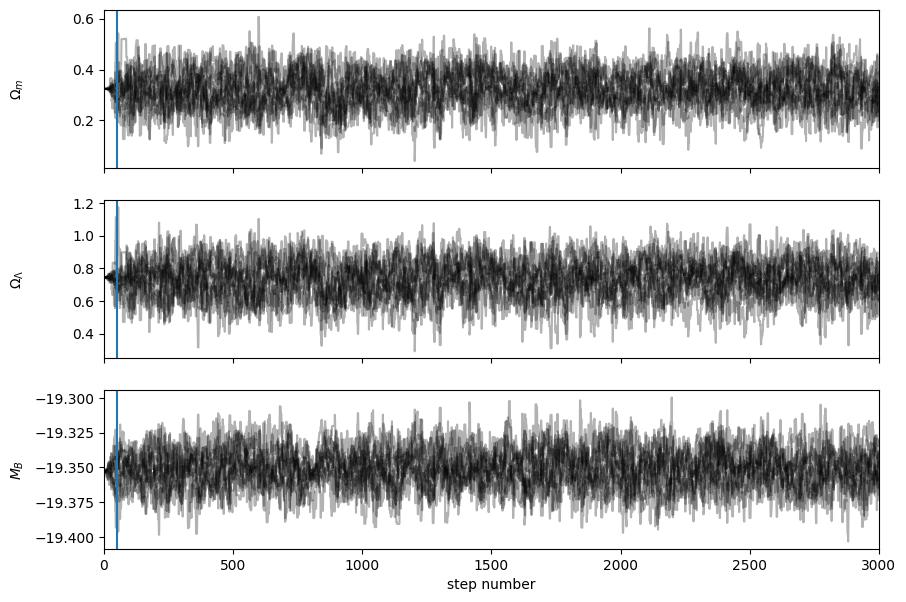

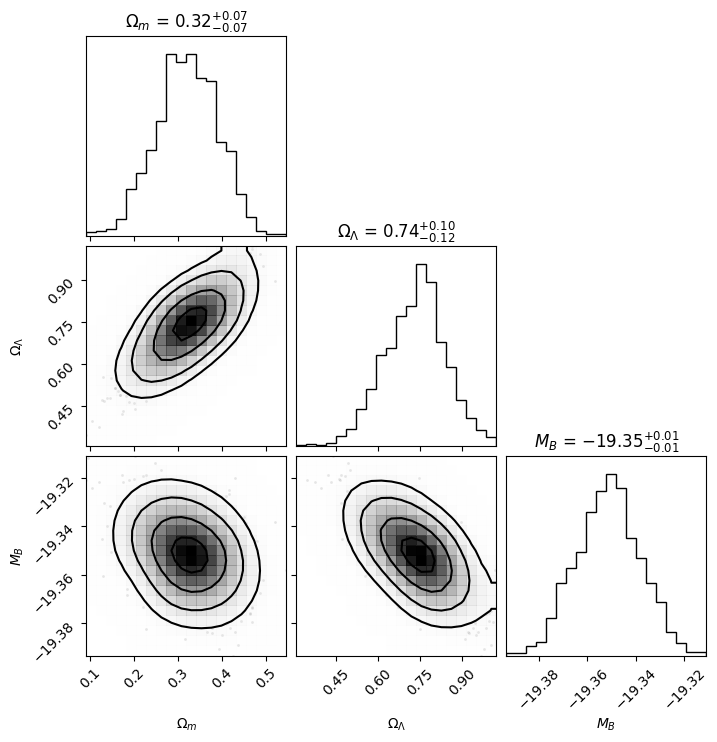

In [50]:
# LCDM
# initialize my MCMC:
model = 1
nwalker = 12
ndim = Nparams[model]
niter = 3000

# initial condition:
theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True);



fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"$\Omega_\Lambda$" ,r"$M_B$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number");

# AutocorrelatioN:
tau = sampler.get_autocorr_time()
print(tau)
nburn = 50 # remove the first nburn iterations
nthin = 30 # remove every nthin iteration to remove the correlation

flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)


fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("flat_lcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model]['DIC'] = DIC_value
print (df)

100%|██████████| 8000/8000 [17:52<00:00,  7.46it/s]


(3180, 3)
[  0.31279782  -1.07965793 -19.35193631]
1029.3253780857065
      Model          AIC          BIC  DIC      chi2min chi2min/dof
0  FlatLCDM  1030.861849  1040.771127  NaN  1026.861849    0.981703
1      LCDM  1032.714967  1047.578883  NaN  1026.714967    0.982502
2  FlatwCDM   1032.81088  1047.674797  NaN   1026.81088    0.982594
3      wCDM  1034.434145    1054.2527  NaN  1026.434145    0.983174


<ipython-input-70-9c150ed4726c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[model]['DIC'] = DIC_value


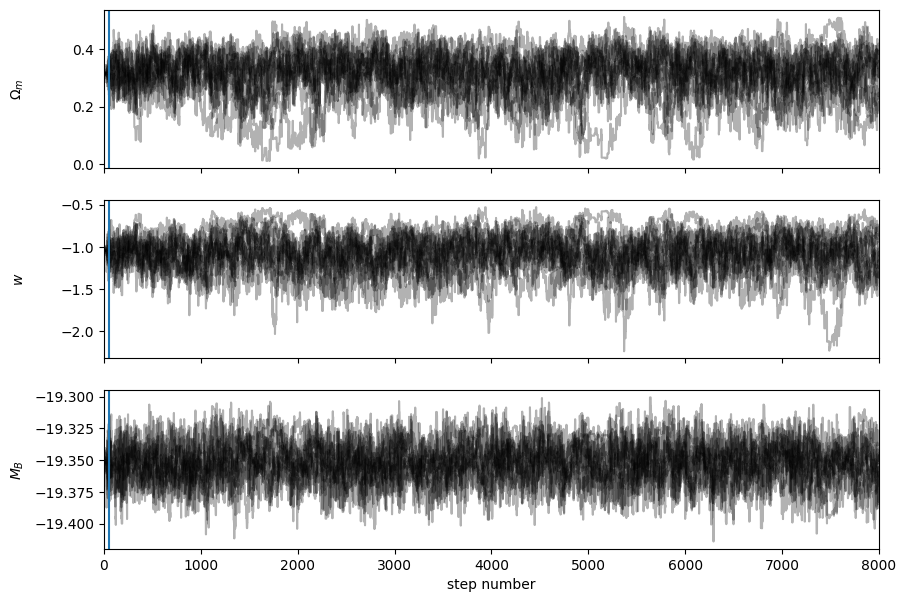

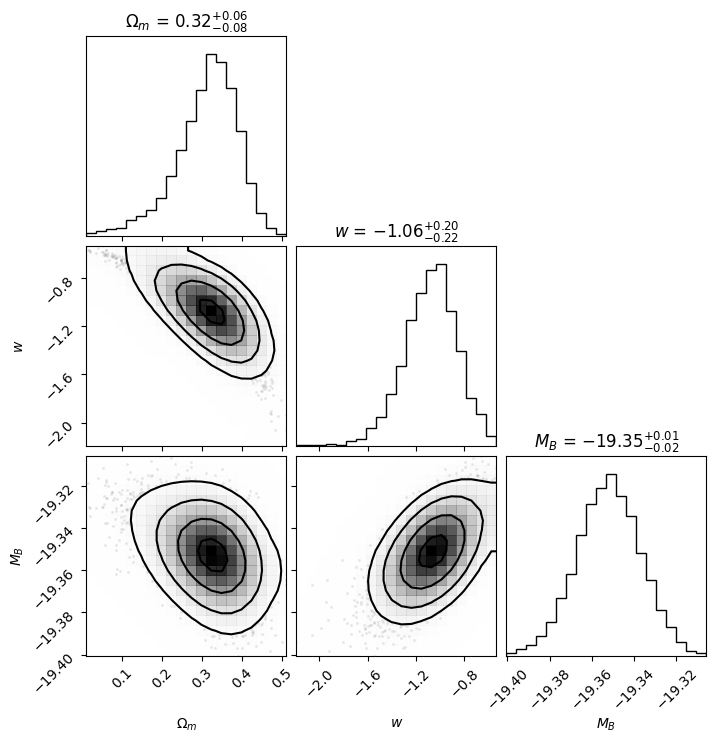

In [70]:
# flatwCDM
model = 2
nwalker = 12
ndim = Nparams[model]
niter = 8000

theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True);



fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"$w$" ,r"$M_B$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number");

nburn = 50
nthin = 30

flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)

fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("flat_wcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model]['DIC'] = DIC_value
print (df)

In [ ]:
# wCDM
model = 3
nwalker = 12
ndim = Nparams[model]
niter = 27000

theta0 = thetahat[model] + 1e-4 * np.random.randn(nwalker, ndim)
nwalkers, ndim = theta0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnP, args=(model,data))
sampler.run_mcmc(theta0, niter, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Omega_m$", r"$\Omega_\Lambda$", r"$w$" ,r"$M_B$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.axvline(x=50)
axes[-1].set_xlabel("step number")

nburn = 50
nthin = 30

flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
print(flat_samples.shape)
thetamean = flat_samples.mean(axis=0)
print(thetamean)

fig = corner.corner(
    flat_samples, labels=labels, truth=thetahat, smooth=2.,show_titles=True
);

fig.savefig("wcdm.pdf",dpi=600)

DIC_value = DIC(sampler,thetamean)
print (DIC_value)
df.loc[model]['DIC'] = DIC_value
print (df)

 17%|█▋        | 4551/27000 [08:58<41:28,  9.02it/s]